# Example for the information theory QPE

In [1]:
import numpy as np
from pytket.circuit.display import render_circuit_jupyter

In [2]:
# Prepare the samples of (k, beta).
k_max = 5
n_samples = 25
k_list = np.random.randint(1, k_max+1, size=n_samples).tolist()
beta_list = (1 - 2 * np.random.random(size=n_samples)).tolist()

In [3]:
# Prepare the iterative QPE circuits.
from h2xh2.experiment import build_iqpe_circuits

logical_circuits = build_iqpe_circuits(
    k_list=k_list,
    beta_list=beta_list,
    pft_rz=False,
    qec_level=0,
)
render_circuit_jupyter(logical_circuits[1])

In [4]:
# Encode the logical circuit.
from h2xh2.encode import steane

encoded_circuits = [
    steane.encode(
        circ,
        options=steane.EncodeOptions(
            # rz_mode=steane.RzMode.BIN_FRAC_NON_FT,
            # rz_options=steane.RzOptionsBinFracNonFT(max_bits=5),
            rz_mode=steane.RzMode.DIRECT,
        )
    ) for circ in logical_circuits
]
render_circuit_jupyter(encoded_circuits[1])

In [5]:
# Compile the encoded circuits.
from pytket.extensions.quantinuum import (
    QuantinuumBackend,
    QuantinuumAPIOffline,
)

backend = QuantinuumBackend(
    device_name="H2-1LE",
    api_handler=QuantinuumAPIOffline(),
)
compiled_circuits = backend.get_compiled_circuits(
    encoded_circuits,
    optimisation_level=0,
)

In [6]:
# Execute the compiled (encoded) circuits.
N_SHOTS = 5

encoded_results = backend.run_circuits(
    compiled_circuits,
    n_shots=N_SHOTS,
)

In [7]:
# Interpret the encoded results back in the logical space.
logical_results = [
    steane.interpret(
        result,
        options=steane.InterpretOptions(
            readout_mode=steane.ReadoutMode.Raw,
        ),
    ) for result in encoded_results
]

In [8]:
from h2xh2.experiment import ChemData
from h2xh2.algorithm import bootstrap_sampling, get_ms, bayesian_update

# Load the pre-computed chemistry data.
chem_data = ChemData()

ks, betas, ms = get_ms(k_list, beta_list, logical_results)

# Prepare the uniform prior distribution.
n_grid_points = 2 ** 10
phi = np.linspace(-1, 1, n_grid_points+1)[:-1]
prior = np.ones_like(phi)

mu, sigma = bootstrap_sampling(phi, ks, betas, ms)
mu_energy = -mu / chem_data.DELTAT
sigma_energy = sigma / chem_data.DELTAT
print(f"Energy estimate = {mu_energy:11.5f} Ha")
print(f"Energy sigma    = {sigma_energy:11.5f} Ha")
print(f"FCI energy      = {chem_data.FCI_ENERGY:11.5f} Ha")

Energy estimate =    -1.12379 Ha
Energy sigma    =     0.02369 Ha
FCI energy      =    -1.13731 Ha


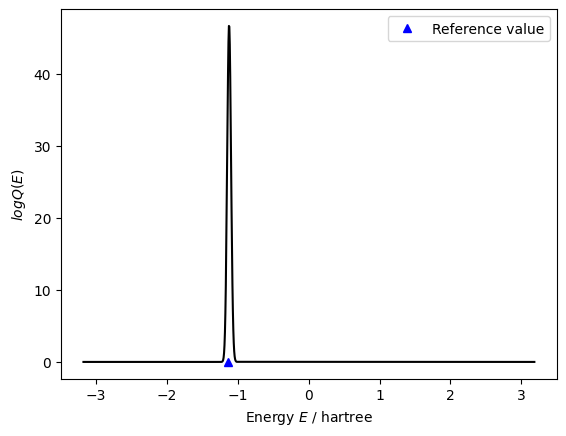

In [ ]:
import matplotlib.pyplot as plt

posterior = bayesian_update(phi, prior, k_list, beta_list, logical_results)
x_energy = -phi / chem_data.DELTAT
plt.plot(x_energy, posterior, "k-")
plt.plot(chem_data.APPROX_ENERGY, 0, "b^", label="Reference value")
plt.xlabel(r"Energy $E$ / hartree")
plt.ylabel(r"$log Q(E)$")
plt.legend()